# Segmenting and Clustering Neighborhoods in Toronto #

## Import Dependencies ##

In [1]:
#%% Import Dependencies
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import math # library to handle complex calculations
import matplotlib.pyplot as plt # library for data visualization

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import wget #download files

print('Libraries imported.')

Libraries imported.


## Get Postal Codes Data from Wikipedia into DataFrame ##

In [2]:
#%% Get Postal Codes Data
df0 = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
df1=df0[0].copy()
df1.head()

,0,1,2
0,Postal Code,Borough,Neighborhood
1,M1A,Not assigned,NaN
2,M2A,Not assigned,NaN
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village


## Group Neighbourhoods by Borough ##

In [3]:
#%% Process Postal Codes Data
column_names=df1.iloc[0]

# Use English spelling for Neighbourhood
column_names[2]='Neighbourhood'

#Set 1st row as column names
df1.columns=column_names
df1.drop(df1.index[0], inplace=True)

# Filter out Neighbourhoods where Borough is not assigned
df1=df1[df1['Borough']!='Not assigned']
df1['Neighbourhood'][df1['Neighbourhood']=='Not assigned']=\
    df1['Borough'][df1['Neighbourhood']=='Not assigned']


#Group Neighbourhoods by Postal Code and Borough
df2=df1.groupby(['Postal Code','Borough'])['Neighbourhood'].apply(lambda x: "%s" % ', '.join(x)).to_frame()
df2.reset_index(inplace=True)

df2.head()

,Postal Code,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


## Download Toronto Geospatial Data ##

In [4]:
#%% Download Geo Data
import wget
url='https://cocl.us/Geospatial_data'
filename=wget.download(url)
filename

100% [............................................................] 2891 / 2891

'Geospatial_Coordinates (1).csv'

## Merge Postal Code and Geo Data ##

In [5]:
#%% #Merge Postal Code and Geo Data
df3=pd.read_csv(filename)
df2=pd.concat([df2,df3], axis=1)
df2.drop(['Postal Code'], axis=1, inplace=True)
print(df2.shape)
df2.head(11)


(103, 4)


,Borough,Neighbourhood,Latitude,Longitude
0,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,Scarborough,Woburn,43.770992,-79.216917
4,Scarborough,Cedarbrae,43.773136,-79.239476
5,Scarborough,Scarborough Village,43.744734,-79.239476
6,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029
7,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577
8,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476
9,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


## Merge Neighbourhood and Geo Data##

In [6]:
#%% Get Neighbourhood Geo Info
# Unroll Neighbourhood Names to dataframe
df4 = pd.DataFrame(df2.Neighbourhood.str.split(', ').tolist()).stack().to_frame()
df4.reset_index(inplace=True)

# Match Borough/Lat/Lon (Geo Data) to the Neighbourhood names
df4[1]=df2['Borough'].iloc[df4['level_0']].values
df4[2]=df2['Latitude'].iloc[df4['level_0']].values
df4[3]=df2['Longitude'].iloc[df4['level_0']].values

# Clean up and rename resulting df
df4.drop(['level_0','level_1'], axis=1, inplace=True)
df4.columns=['Neighbourhood','Borough','Latitude','Longitude']
df4.head()

,Neighbourhood,Borough,Latitude,Longitude
0,Malvern,Scarborough,43.806686,-79.194353
1,Rouge,Scarborough,43.806686,-79.194353
2,Rouge Hill,Scarborough,43.784535,-79.160497
3,Port Union,Scarborough,43.784535,-79.160497
4,Highland Creek,Scarborough,43.784535,-79.160497


## Get Demographics of Toronto Neighbourhoods and merge with Geo Data##

In [7]:
#%% Demographics of Toronto neighbourhoods
df0A = pd.read_html("https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods")
df0B=df0A[1].copy()

#Get column headers for Toronto Demographic Data and reindex
column_names=df0B.iloc[0]
column_names[0]='Neighbourhood'
df0B.columns=column_names
df0B.drop(df0B.index[0], inplace=True)
df0B.head()

#% Combine Neighbourhood Info with Demographic Data
df5=pd.merge(df0B, df4, on='Neighbourhood')

#Only Keep Unique Neighbourhood Names
df5=df5.drop_duplicates(subset=['Neighbourhood'])
df5.head()

,Neighbourhood,FM,Census Tracts,Population,Land area (km2),Density (people/km2),% Change in Population since 2001,Average Income,Transit Commuting %,% Renters,Second most common language (after English) by name,Second most common language (after English) by percentage,Map,Borough,Latitude,Longitude
0,Agincourt,S,"0377.01, 0377.02, 0377.03, 0377.04, 0378.02, 0...",44577,12.45,3580,4.6,25750,11.1,5.9,Cantonese (19.3%),19.3% Cantonese,NaN,Scarborough,43.794200,-79.262029
1,Alderwood,E,"0211.00, 0212.00",11656,4.94,2360,-4.0,35239,8.8,8.5,Polish (6.2%),06.2% Polish,NaN,Etobicoke,43.602414,-79.543484
2,Bathurst Manor,NY,"0297.01, 0310.01, 0310.02",14945,4.69,3187,12.3,34169,13.4,18.6,Russian (9.5%),09.5% Russian,NaN,North York,43.754328,-79.442259
3,Bayview Village,NY,"0305.01, 305.02",12280,4.14,2966,41.6,46752,14.4,15.6,Cantonese (8.4%),08.4% Cantonese,NaN,North York,43.786947,-79.385975
4,Bedford Park,OCoT,"0141.01, 0141.02, 0142.00",13749,2.27,6057,-1.4,80827,15.2,10.1,Greek (0.7%),00.7% Greek,NaN,North York,43.733283,-79.419750


## Function to calculate the min distance between two geo points ##

In [8]:
#%% Calculate the minimum distance between each neighbouthood and the next closest
# Using the Haversign Formula, this will determin the adequate radius to 
# input in the venus formula

def CalcDistance(lat1, lon1, lat2, lon2):
    
    # radius of the Earth in km
    R = 6373.0
    
    # Convert coordinates to radians
    lat1 = math.radians(lat1)    
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)
    
    # change in coordinates
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    # Haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    #Get Distance in km
    distance = R * c
    
    #Get Distance in feet
    distance = int(distance * 3280.84)
    
    # print(distance)
    return(distance)

## Determine the closest neighbourhood and calculate the custom radius  ##
### Add the result to the dataframe  ###

In [9]:
n0=len(df5)
n3=0
dfidx=np.arange(n0)

v4=[]
for n1 in range(n0):
    v2=[]
    for n2 in range(n0):
        if n1 != n2:
            # print(n1,n2)
            n3+=1
            lat1, lon1 = df5[['Latitude','Longitude']].iloc[n1]
            lat2, lon2 = df5[['Latitude','Longitude']].iloc[n2]
            v1=CalcDistance(lat1, lon1, lat2, lon2)
            if v1 != 0:
                v1=[n1,n2,v1]
                v2.append(v1)
    v3=np.asarray(v2)
    v3=v3[np.argsort(v3[:,2], axis=0),:]
    v4.append(v3[0,:])

v5=np.asarray(v4)
df5['Nearest Neighbourhood']=df5['Neighbourhood'].iloc[v5[:,1]].values
df5['NN Distance']=v5[:,2]
df5['Radius']=df5['NN Distance']/2
df5.head()

,Neighbourhood,FM,Census Tracts,Population,Land area (km2),Density (people/km2),% Change in Population since 2001,Average Income,Transit Commuting %,% Renters,Second most common language (after English) by name,Second most common language (after English) by percentage,Map,Borough,Latitude,Longitude,Nearest Neighbourhood,NN Distance,Radius
0,Agincourt,S,"0377.01, 0377.02, 0377.03, 0377.04, 0378.02, 0...",44577,12.45,3580,4.6,25750,11.1,5.9,Cantonese (19.3%),19.3% Cantonese,NaN,Scarborough,43.794200,-79.262029,Milliken,9709,4854.5
1,Alderwood,E,"0211.00, 0212.00",11656,4.94,2360,-4.0,35239,8.8,8.5,Polish (6.2%),06.2% Polish,NaN,Etobicoke,43.602414,-79.543484,New Toronto,11204,5602.0
2,Bathurst Manor,NY,"0297.01, 0310.01, 0310.02",14945,4.69,3187,12.3,34169,13.4,18.6,Russian (9.5%),09.5% Russian,NaN,North York,43.754328,-79.442259,Downsview,8545,4272.5
3,Bayview Village,NY,"0305.01, 305.02",12280,4.14,2966,41.6,46752,14.4,15.6,Cantonese (8.4%),08.4% Cantonese,NaN,North York,43.786947,-79.385975,Newtonbrook,5981,2990.5
4,Bedford Park,OCoT,"0141.01, 0141.02, 0142.00",13749,2.27,6057,-1.4,80827,15.2,10.1,Greek (0.7%),00.7% Greek,NaN,North York,43.733283,-79.419750,Lawrence Park,8386,4193.0


## Get Toronto Coordinates ##

In [10]:
#%% Toronto Coordinates
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


## Create Toronto Test Map ##

In [27]:
#%% Test Map

# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighbourhood in zip(df5['Latitude'], \
                df5['Longitude'], df5['Borough'], df5['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)
    
map_Toronto

## Save Foursquare Login Info ##

In [12]:
# @hidden_cell
#Foursquare Login Info
CLIENT_ID = 'EH5NVS3H0UK5L4J43OQX4U5VSVIGPSGEOL5CAES4EEPABSBO' # your Foursquare ID
CLIENT_SECRET = '1L1UWLPCTNWWSEKDAVDLNPDI043MFYXR4WZA3PIO051KXO0V' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EH5NVS3H0UK5L4J43OQX4U5VSVIGPSGEOL5CAES4EEPABSBO
CLIENT_SECRET:1L1UWLPCTNWWSEKDAVDLNPDI043MFYXR4WZA3PIO051KXO0V


## Define Function to get venues for each neighbourhood from Foursquare, Run Function ##

In [13]:
#%% Function to get venues in each neighbourhood
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng, rad in zip(names, latitudes, longitudes, radius):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            rad, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
#%%
LIMIT=100
# radius=500
toronto_venues = getNearbyVenues(names=df5['Neighbourhood'],
                                   latitudes=df5['Latitude'],
                                   longitudes=df5['Longitude'],
                                   radius=df5['Radius']
                                  )

Agincourt
Alderwood
Bathurst Manor
Bayview Village
Bedford Park
Birch Cliff
Brockton
Cabbagetown
Church and Wellesley
Clairlea
Cliffcrest
Cliffside
Davisville
Deer Park
Don Mills
Dorset Park
Downsview
Eringate
Garden District
Grange Park
Guildwood
Henry Farm
Highland Creek
Humber Bay Shores
Humber Summit
Humber Valley Village
Humberlea
Ionview
Kensington Market
Kingsview Village
Lawrence Heights
Lawrence Manor
Lawrence Park
Leaside
Little Portugal
Long Branch
Malvern
Markland Wood
Maryvale
Milliken
Moore Park
Morningside
Mount Dennis
New Toronto
Newtonbrook
Oakridge
Parkdale
Parkwoods
Port Union
Princess Gardens
Riverdale
Roncesvalles
Rosedale
Rouge
Rouge Hill
Runnymede
Scarborough Village
South Hill
St. James Town
Sunnylea
Swansea
The Annex
The Beaches
The Kingsway
Thistletown
Thorncliffe Park
Toronto Islands
Victoria Village
West Deane Park
West Hill
Westmount
Weston
Wexford
Willowdale
Wilson Heights
Woburn
York Mills
Yorkville


In [ ]:
print(toronto_venues.shape)
toronto_venues.head()

## Group Venues to get List of Neighbourhoods ##
### Ensure no errors if a neighbourhood has no venues, inpect the number of venues per neighbourhood ###

In [16]:
#%% Ensure No Errors if Neighbourhood has no venues
df6=toronto_venues.groupby('Neighbourhood').mean()
#df5

df6.drop(['Venue Latitude','Venue Longitude'], axis=1, inplace=True)
df6.reset_index(inplace=True)
#print(df5.shape)
#df5

df7=toronto_venues.groupby('Neighbourhood')['Venue Category'].count()
df7.head()

Neighbourhood
Agincourt          100
Alderwood          100
Bathurst Manor     100
Bayview Village    100
Bedford Park       100
Name: Venue Category, dtype: int64

## Perform One Hot Encoding for each Venue Category, Get Average per Neighbourhood ##

In [17]:
#%% Apply one hot encoding for each venue by its category
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add Neighbourhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move Neighbourhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

#Group by Neighbourhood, aggregate one hot encoding to develop a venue category score
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
#print(toronto_grouped.shape)
toronto_grouped.head()
#toronto_onehot.head()

,Neighbourhood,Afghan Restaurant,Airport,American Restaurant,Amphitheater,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Big Box Store,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Campground,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Hong Kong Restaurant,Hookah Bar,Hostel,Hotel,Hotpot Restaurant,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,National Park,Neighborhood,New American Restaurant,Nightclub,Noodle House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Climbing Spot,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Ski Chalet,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stables,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Agincourt,0.0,0.00,0.01,0.0,0.0,0.01,0.01,0.00,0.0,0.0,0.00,0.0,0.00,0.03,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.03,0.0,0.0,0.0,0.0,0.02,0.00,0.00,0.0,0.03,0.02,0.01,0.0,0.0,0.00

## Top 20 venues for each Neighbourhood ##

In [19]:
#%%
# Get the 20 most common venues for each neighbourhood
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 20

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,Agincourt,Chinese Restaurant,Supermarket,Caribbean Restaurant,Indian Restaurant,Coffee Shop,Restaurant,Park,Pharmacy,Bakery,Clothing Store,Bubble Tea Shop,Noodle House,Bookstore,Gym,Sushi Restaurant,Sri Lankan Restaurant,Hakka Restaurant,Seafood Restaurant,Breakfast Spot,Gym / Fitness Center
1,Alderwood,Coffee Shop,Bakery,Café,Burger Joint,Ice Cream Shop,Park,Pizza Place,Burrito Place,Seafood Restaurant,Breakfast Spot,Grocery Store,Brewery,Sporting Goods Shop,Restaurant,Liquor Store,Vietnamese Restaurant,Wings Joint,Greek Restaurant,Fast Food Restaurant,Middle Eastern Restaurant
2,Bathurst Manor,Coffee Shop,Restaurant,Grocery Store,Clothing Store,Bagel Shop,Bakery,Bubble Tea Shop,Bookstore,Café,Mediterranean Restaurant,Park,Sushi Restaurant,Cosmetics Shop,Deli / Bodega,Burger Joint,Middle Eastern Restaurant,Steakhouse,Tea Room,French Restaurant,Toy / Game Store
3,Bayview Village,Korean Restaurant,Coffee Shop,Pizza Place,Chinese Restaurant,Sandwich Place,Bank,Furniture / Home Store,Bubble Tea Shop,Gas Station,Sushi Restaurant,Pharmacy,Thai Restaurant,Bakery,Trail,Middle Eastern Restaurant,Café,Supermarket,Liquor Store,Grocery Store,Shopping Mall
4,Bedford Park,Coffee Shop,Café,Grocery Store,Japanese Restaurant,Italian Restaurant,Burger Joint,Park,Bakery,Pharmacy,Tea Room,Plaza,Supermarket,Dessert Shop,Fried Chicken Joint,Sandwich Place,Shopping Mall,Middle Eastern Restaurant,Pizza Place,Hotel,Poke Place


## K-Means Clustering on Average Dataset add labels to Dataframe ##

In [20]:
#%% Perform KMeans Clustering

# set number of clusters
kclusters = 10

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

df5['KMeans Label']=kmeans.labels_
df5.head()

,Neighbourhood,FM,Census Tracts,Population,Land area (km2),Density (people/km2),% Change in Population since 2001,Average Income,Transit Commuting %,% Renters,Second most common language (after English) by name,Second most common language (after English) by percentage,Map,Borough,Latitude,Longitude,Nearest Neighbourhood,NN Distance,Radius,KMeans Label
0,Agincourt,S,"0377.01, 0377.02, 0377.03, 0377.04, 0378.02, 0...",44577,12.45,3580,4.6,25750,11.1,5.9,Cantonese (19.3%),19.3% Cantonese,NaN,Scarborough,43.794200,-79.262029,Milliken,9709,4854.5,0
1,Alderwood,E,"0211.00, 0212.00",11656,4.94,2360,-4.0,35239,8.8,8.5,Polish (6.2%),06.2% Polish,NaN,Etobicoke,43.602414,-79.543484,New Toronto,11204,5602.0,4
2,Bathurst Manor,NY,"0297.01, 0310.01, 0310.02",14945,4.69,3187,12.3,34169,13.4,18.6,Russian (9.5%),09.5% Russian,NaN,North York,43.754328,-79.442259,Downsview,8545,4272.5,5
3,Bayview Village,NY,"0305.01, 305.02",12280,4.14,2966,41.6,46752,14.4,15.6,Cantonese (8.4%),08.4% Cantonese,NaN,North York,43.786947,-79.385975,Newtonbrook,5981,2990.5,7
4,Bedford Park,OCoT,"0141.01, 0141.02, 0142.00",13749,2.27,6057,-1.4,80827,15.2,10.1,Greek (0.7%),00.7% Greek,NaN,North York,43.733283,-79.419750,Lawrence Park,8386,4193.0,9


Text(0.5,1,'Elbow Analysis K 1:30')

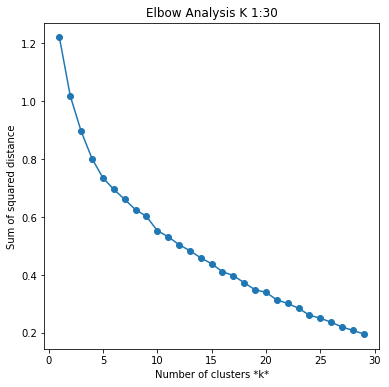

In [21]:
#%% Elbow Method for K selection
# Run the Kmeans algorithm and get the index of data points clusters
sse = []
end = 30
list_k = list(range(1, end))
X=toronto_grouped_clustering

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');
plt.title('Elbow Analysis K 1:' + str(end))

## Create cluster map of neighbourhoods in Folium and Display Map##

In [24]:
#%% Create cluster map of neighbourhoods in Folium and Display Map
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df5['Latitude'], df5['Longitude'], df5['Neighbourhood'], df5['KMeans Label']):
    label = folium.Popup(str(poi) + ' Label ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

# Determine the best neighbourhood #

In [40]:
#%% 
# Get list of Toronto Caribbean Restuarant Venues
venue_cat='Caribbean Restaurant'
# venue_cat='Bakery'
# venue_name="George's Tastee Foods"
toronto_venues_cat=toronto_venues[toronto_venues['Venue Category']==\
                                     venue_cat]

neighbourhood_current='Milliken'
# neighbourhood_current='Eringate'
label_current=df5['KMeans Label'][df5['Neighbourhood']==\
                neighbourhood_current].iloc[0]

#Similar Neighbourhoods
df8=df5[df5['KMeans Label']==label_current]

# Similar Neighbourhoods with same venue category score
toronto_grouped_venuecat=toronto_grouped[['Neighbourhood', venue_cat]]
df8=pd.merge(df8, toronto_grouped_venuecat, on='Neighbourhood')

# Get minimum score (Similar neighbourhoods with least competition)
min_score=df8[venue_cat].iloc[df8[venue_cat].idxmin]
#print(min_score)


# Filter neighbourhoods with same min score
df9=df8[df8[venue_cat]==min_score]

# Convert Demographic Metrics to numeric format
# Evaluate the lowest competition neighbourhoods on the following 3 metrics
# Highest Population, highest % population increase, highest average income
df10=df9[['Population','% Change in Population since 2001','Average Income']]\
    .apply(pd.to_numeric)
    
#Get Score for each metric
min01=df10.min(axis=0)
max01=df10.max(axis=0)
df11=(df10-min01)/(max01-min01)

#Apply Score to filtered dataframe
df9['Score']=df11.sum(axis=1)
df9=df9.sort_values('Score')

df9.head(20)

C:\Users\MainAdmin\Miniconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Neighbourhood,FM,Census Tracts,Population,Land area (km2),Density (people/km2),% Change in Population since 2001,Average Income,Transit Commuting %,% Renters,Second most common language (after English) by name,Second most common language (after English) by percentage,Map,Borough,Latitude,Longitude,Nearest Neighbourhood,NN Distance,Radius,KMeans Label,Caribbean Restaurant,Score
8,Oakridge,S,"0341.02, 0341.03, 0341.04",13368,1.86,7187,-2.3,21155,20.8,27.1,Bengali (12.6%),12.6% Bengali,NaN,Scarborough,43.711112,-79.284577,Birch Cliff,8511,4255.5,0,0.01,0.649154
5,Ionview,S,"0346.02, 0351.01, 0351.02",13025,1.94,6714,-4.0,25078,21.1,22.5,Filipino (6.5%),06.5% Filipino,NaN,Scarborough,43.727929,-79.262029,Cliffside,7303,3651.5,0,0.01,0.787746
6,Maryvale,S,"0372.00, 0373.00",8800,2.28,3860,-3.2,30944,12.3,11.4,Filipino (4.1%),04.1% Filipino,NaN,Scarborough,43.750072,-79.295849,Dorset Park,6518,3259.0,0,0.01,0.867748
11,Wexford,S,"0349.00, 0350.00, 0371.00",17844,7.97,2239,-3.2,28556,14.0,15.1,Filipino (4.5%),04.5% Filipino,NaN,Scarborough,43.750072,-79.295849,Dorset Park,6518,3259.0,0,0.01,1.672602
1,Clairlea,S,"0340.00, 0348.00",11104,3.58,3102,1.8,33392,18.1,12.7,Filipino (4.3%),04.3% Filipino,NaN,Scarborough,43.711112,-79.284577,Birch Cliff,8511,4255.5,0,0.01,1.746280
3,Dorset Park,S,"0352.00, 0370.02, 0370.03",14189,4.26,3331,7.8,26525,15.2,9.6,Tamil (9.5%),09.5% Tamil,NaN,Scarborough,43.757410,-79.273304,Wexford,6518,3259.0,0,0.01,2.034698
10,Victoria Village,NY,"0261.00, 0262.01, 0262.02",17047,4.72,3612,2.5,29657,15.6,23.4,Urdu (3.2%),03.2% Urdu,NaN,North York,43.725882,-79.315572,Oakridge,9791,4895.5,0,0.01,2.157501


In [31]:
#Get Neighbourhood with Lowest Competiion and Maximum Demographics Score
neighbourhood_best=df9['Neighbourhood'].iloc[-1]

print(neighbourhood_best)

Victoria Village
